<a href="https://colab.research.google.com/github/sangbin0106/Project/blob/main/PJ2%20%EC%9D%B4%EC%83%81%EB%B9%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트 설명

지인과 이야기를 나누던 도중 구내식당이야기가 나오면서, 잔반이 많이 나오더라라는 말에 고객방문의 예측이 가능하다면 재료를 효율적으로 관리하며, 매출 또한 예측이 가능할것같아 데이터를 검색중 발견하여 주제를 선정했습니다.  

직원들의 요일별로 점심,저녁을 얼마나하는지, 식수인원예측모델을 만들어 보았습니다.

**데이터불러오기 및 패키지설치**

In [1]:
# 데이터 불러오기
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

In [3]:
train = pd.read_csv('/content/drive/MyDrive/PJ2/train.csv')
test = pd.read_csv('/content/drive/MyDrive/PJ2/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/PJ2/sample_submission.csv')

**결측치확인**

In [4]:
train.isna().any()

일자                False
요일                False
본사정원수             False
본사휴가자수            False
본사출장자수            False
본사시간외근무명령서승인건수    False
현본사소속재택근무자수       False
조식메뉴              False
중식메뉴              False
석식메뉴              False
중식계               False
석식계               False
dtype: bool

In [5]:
test.isna().any()

일자                False
요일                False
본사정원수             False
본사휴가자수            False
본사출장자수            False
본사시간외근무명령서승인건수    False
현본사소속재택근무자수       False
조식메뉴              False
중식메뉴              False
석식메뉴              False
dtype: bool

**베이스라인설계**

In [6]:
#타겟분리
train['요일'] = train['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})
test['요일'] = test['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})

x_train = train[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]
y1_train = train['중식계']
y2_train = train['석식계']

x_test = test[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]

In [7]:
# 점심 저녁을 예측할 모델 2개 생성 및 학습
from sklearn.metrics import accuracy_score
params = {
    'min_samples_leaf' :[10,12,15],
    'max_depth' : [1, 5, 10, 20],
}

model1 = RandomForestRegressor(n_jobs=-1, random_state=42)
model2 = RandomForestRegressor(n_jobs=-1, random_state=42)

lunch_model = RandomizedSearchCV(model1, params, scoring='neg_mean_absolute_error')
dinner_model = RandomizedSearchCV(model2, params, scoring='neg_mean_absolute_error')

lunch_model.fit(x_train, y1_train)
dinner_model.fit(x_train, y2_train)

lunch_best = lunch_model.best_score_
dinner_best = dinner_model.best_score_
print('점심 베이스라인 모델 에러값(mae) : ',lunch_best)
print('저녁 베이스라인 모델 에러값(mae) : ', dinner_best)

점심 베이스라인 모델 에러값(mae) :  -91.63713488457338
저녁 베이스라인 모델 에러값(mae) :  -85.18297694820242


In [8]:
# 일자 : date, 요일 : dow, 본사정원수 : employees, 본사휴가자수 : dayoff
# 본사출장자수 : bustrip, 본사시간외근무명령서승인건수 : ovtime, 현본사소속재택근무자수 : remote
train_eng = train.copy()
test_eng = test.copy()

train_eng.columns = ['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'brk', 'ln', 'dn', 'target_ln', 'target_dn']


In [9]:
test_eng = test.copy()
test_eng.columns = ['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'brk', 'ln', 'dn']

**타겟분포확인**

저녁 이용자수는 특이하게 0명인 날이 존재 예상(저녁의 mae값을 줄이는데 주력) 그리고 이용자수는 몇 백명 (100~800여 명)정도의 범위이고, 전반적으로 점심보다 저녁 이용자수가 더 적다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103

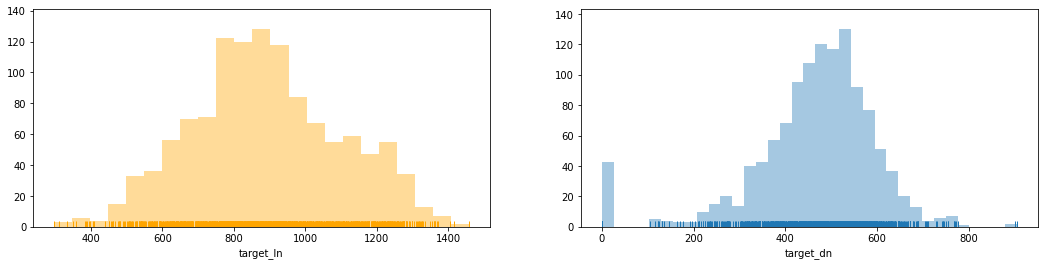

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 4))
sns.distplot(train_eng["target_ln"], ax = ax[0], color = 'orange', kde = False, rug = True)
sns.distplot(train_eng["target_dn"], ax = ax[1], kde = False, rug = True)
plt.show()

- **코로나 전후 점심과 저녁 이용자수 평균 변화 확인**

In [11]:
before_covid = train_eng[(train_eng['date'] >= '2019-01-01')&(train_eng['date'] <= '2019-12-31')][['date', 'target_ln', 'target_dn']]
after_covid = train_eng[train_eng['date'] >= '2020-01-01'][['date', 'target_ln', 'target_dn']]
print('점심:', '2019년에는', round(before_covid.target_ln.mean(), 2), ', 2020년에는', round(after_covid.target_ln.mean(), 2))
print('저녁:', '2019년에는', round(before_covid.target_dn.mean(), 2), ', 2020년에는', round(after_covid.target_dn.mean(), 2))

점심: 2019년에는 850.51 , 2020년에는 890.97
저녁: 2019년에는 445.39 , 2020년에는 428.34


점심: 2019년에는 **850.51** , 2020년에는 **890.97**

저녁: 2019년에는 **445.39** , 2020년에는 **428.34**

2019년과 2020년만을 따로 보니, 딱히 코로나19로 인해 점심/저녁 이용자수가 크게 달라진 것 같진 않습니다

오히려 점심의 경우, 2020년 이용자수 평균(890명)이 2019년(850명)보다 높았습니다.

**2020년동안 직원수의 증가여부확인**

In [12]:
train_eng1 = train_eng
def year1(str):
    return str[0:4]
train_eng1['year'] = train_eng['date'].apply(year1)
train_eng1 = train_eng1[['employees','year']].groupby(train_eng1['year']).sum()
train_eng1

,employees
year,
2016,603833
2017,649684
2018,660756
2019,728832
2020,689602
2021,50711


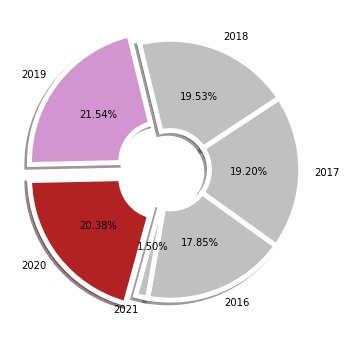

In [13]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 6]
colors = ['silver', 'silver','silver', '#d395d0', 'firebrick', 'silver']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.pie(train_eng1['employees'],labels = train_eng1.index, startangle=260, autopct='%.2f%%',
        shadow=True, colors = colors, explode = [0,0,0,0.1,0.1,0],wedgeprops=wedgeprops);

2019년과 2020년만을 비교해보면 딱히 2020년 정원수가 더 많다고는 할 수 없을 것 같습니다.
2019년에 비해 2020년의 총인원수가 늘지 않았기 때문에 코로나의 영향이 있다고 보입니다. 코로나로 인해서 점심외출을 줄이고 사내에서 식사를 했다라고 볼 수 있을 것 같습니다.

 

이전에 석식 이용자수를 확인했을 때 0명인 날들이 있었는데 이게 오류인건지, 아니면 어떤 이유가 있어서인지 확인작업

In [14]:
train_eng[train_eng.target_dn == 0][['date',  'dayoff', 'bustrip', 'ovtime', 'remote', 'dow', 'dn', 'target_dn']].head()

,date,dayoff,bustrip,ovtime,remote,dow,dn,target_dn
204,2016-11-30,68,207,0,0.0,2,*,0.0
224,2016-12-28,166,225,0,0.0,2,*,0.0
244,2017-01-25,79,203,0,0.0,2,*,0.0
262,2017-02-22,75,252,0,0.0,2,*,0.0
281,2017-03-22,53,235,0,0.0,2,*,0.0


In [15]:
len(train_eng[train_eng.target_dn == 0][['date',  'dayoff', 'bustrip', 'ovtime', 'remote', 'dow', 'dn', 'target_dn']])

43

저녁 이용자가 0명이었던 이유는 총 43개 입니다.

월별 마지막 (또는 그 전 주) 수요일(dow가 3인 날)은 '자기개발의 날'이라서 모두 정시 퇴근을 하는 (해야하는)날, 그래서 매달 마지막 수요일마다 0명이 있습니다.
저녁 메뉴가 제공됨에도 불구하고 저녁 이용자가 0명인 날이 딱 2일 있습니다. 2017-09-27와 2018-02-14 입니다. 이 날들은 긴 공휴일 전후의 날짜일까 싶어 확인
예전 달력을 확인해보니, 2017-09-27은 공휴일 직전은 아니었지만, 2017년의 유명한 황금연휴 전 주 개천절, 추석, 대체휴일, 한글날까지 황금연휴
2018-02-14은 예상대로 2018-02-15 ~ 17일까지의 설날 연휴 전날
예측모델에서 마지막주 수요일의 인원을 0명으로 설정

In [16]:
train.corr()[['중식계', '석식계']]

,중식계,석식계
요일,-0.731563,-0.312112
본사정원수,-0.115529,-0.173852
본사휴가자수,-0.391975,-0.316894
본사출장자수,-0.512680,-0.188164
본사시간외근무명령서승인건수,0.535611,0.571168
현본사소속재택근무자수,0.076509,-0.057534
중식계,1.000000,0.508287
석식계,0.508287,1.000000


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49885 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49437 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49885 missing from current font.
  font.set_te

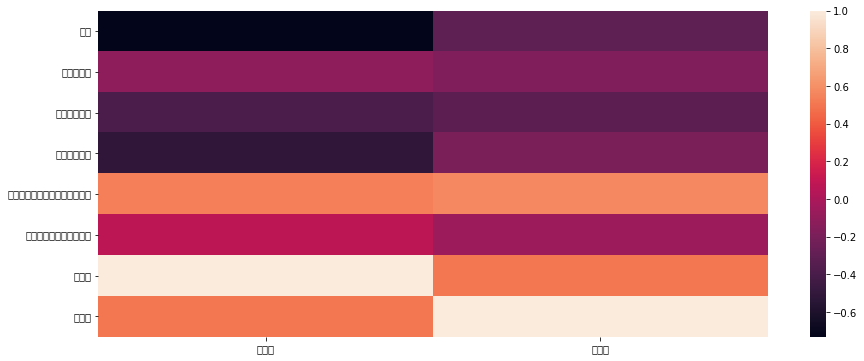

In [17]:
sns.heatmap(train.corr()[['중식계', '석식계']]);

In [18]:
# 일자, 요일은 라벨 인코딩으로 숫자형으로 변환
train_eng['month'] = pd.DatetimeIndex(train_eng['date']).month
test_eng['month'] = pd.DatetimeIndex(test_eng['date']).month

train_eng['day'] = pd.DatetimeIndex(train_eng['date']).day
test_eng['day'] = pd.DatetimeIndex(test_eng['date']).day

In [19]:
# 요일을 숫자로 변환
weekday = {
    '월': 1,
    '화': 2,
    '수': 3,
    '목': 4,
    '금': 5
}
train_eng['dow'] = train_eng['dow'].map(weekday)
test_eng['dow'] = test_eng['dow'].map(weekday)

In [20]:
# 식사가능자수 = 본사정원수 - 본사휴가자수 - 현본사소속재택근무자수
train_eng['real_emp'] = train_eng['employees'] - train_eng['bustrip'] - train_eng['dayoff'] - train_eng['remote']
test_eng['real_emp'] = test_eng['employees'] - train_eng['bustrip'] - test_eng['dayoff'] - test_eng['remote']

In [21]:
# 정확한 식사 참여율 칼럼 만들기
train_eng['ln_rate'] = train_eng['target_ln'] / train_eng['real_emp']
train_eng['dn_rate'] = train_eng['target_dn'] / train_eng['real_emp']

In [22]:
# 요일을 석식 rank에 맞춰 mapping한 요일(석식) 칼럼 만들기.
weekday_rank4dinner = {
    1: 1,
    2: 2,
    3: 5,
    4: 3,
    5: 4,
}

train_eng['dow_dn'] = train_eng['dow'].map(weekday_rank4dinner)
test_eng['dow_dn'] = test_eng['dow'].map(weekday_rank4dinner)

In [23]:
# 메뉴에서 불필요한 문자 제거
lunch = []
for day in range(len(train_eng)):
    tmp = train_eng.iloc[day, 8].split(' ') # 공백으로 문자열 구분 
    tmp = ' '.join(tmp).split()    # 빈 원소 삭제

    search = '('   # 원산지 정보는 삭제
    for menu in tmp:
        if search in menu:
            tmp.remove(menu)
    
    lunch.append(tmp)

In [24]:
np.array(train_eng[ (train_eng.index > 1064) & (train_eng.index < 1069)][['date', 'ln']])

array([['2020-06-11',
        '쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 매운소고기국  굴비구이  토마토프리타타  도라지오이무침  배추겉절이 (배추국내,고추가루:중국산) '],
       ['2020-06-12',
        '돈육버섯고추장덮밥 (쌀,돈육:국내산) 팽이무국  양파링카레튀김  모듬어묵볶음  참나물생채 요구르트 포기김치 (김치:국내산) '],
       ['2020-07-01',
        '쌀밥/잡곡밥 냉모밀국수 매운돈갈비찜 메밀전병*간장 고구마순볶음 포기김치 양상추샐러드*딸기요거트 '],
       ['2020-07-02',
        '쌀밥/잡곡밥 대파육개장 홍어미나리초무침 어묵잡채 콩자반 배추겉절이 양상추샐러드*오리엔탈 ']],
      dtype=object)

메뉴 전처리 과정에서 이상점을 발견

메뉴에서 사이드와 김치의 자리가 2020-07-01부터 순서가 바뀐다.
2020-06-13 ~ 2020-06-30까지는 구내식당이 운영을 하지 않았음
이상점 부분을 반영해서 메뉴칼럼 전처리

In [25]:
# lunch train data에 밥, 국, 반찬 1-3, 김치, 사이드로 구분해서 생성
bob = []; gook = []; banchan1 = []; banchan2 = []; banchan3 = []; kimchi = []; side = []
for i, day_menu in enumerate(lunch):
    bob_tmp = day_menu[0]; bob.append(bob_tmp)
    gook_tmp = day_menu[1]; gook.append(gook_tmp)
    banchan1_tmp = day_menu[2]; banchan1.append(banchan1_tmp)
    banchan2_tmp = day_menu[3]; banchan2.append(banchan2_tmp)
    banchan3_tmp = day_menu[4]; banchan3.append(banchan3_tmp)

    if i < 1067:
        kimchi_tmp = day_menu[-1]; kimchi.append(kimchi_tmp)
        side_tmp = day_menu[-2]; side.append(side_tmp)
    else: 
        kimchi_tmp = day_menu[-2]; kimchi.append(kimchi_tmp)
        side_tmp  = day_menu[-1]; side.append(side_tmp)
        
train_ln = train_eng[['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'ln', 'target_ln']]
train_ln['bob'] = bob
train_ln['gook'] = gook
train_ln['banchan1'] = banchan1; train_ln['banchan2'] = banchan2; train_ln['banchan3'] = banchan3
train_ln['kimchi'] = kimchi 
train_ln['side'] = side
train_ln.iloc[1066:1070, 7:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,ln,target_ln,bob,gook,banchan1,banchan2,banchan3,kimchi,side
1066,"돈육버섯고추장덮밥 (쌀,돈육:국내산) 팽이무국 양파링카레튀김 모듬어묵볶음 참나...",516.0,돈육버섯고추장덮밥,팽이무국,양파링카레튀김,모듬어묵볶음,참나물생채,포기김치,요구르트
1067,쌀밥/잡곡밥 냉모밀국수 매운돈갈비찜 메밀전병*간장 고구마순볶음 포기김치 양상추샐러드...,866.0,쌀밥/잡곡밥,냉모밀국수,매운돈갈비찜,메밀전병*간장,고구마순볶음,포기김치,양상추샐러드*딸기요거트
1068,쌀밥/잡곡밥 대파육개장 홍어미나리초무침 어묵잡채 콩자반 배추겉절이 양상추샐러드*오리엔탈,675.0,쌀밥/잡곡밥,대파육개장,홍어미나리초무침,어묵잡채,콩자반,배추겉절이,양상추샐러드*오리엔탈
1069,카레라이스 동태알탕 부추고추전*간장 쫄면야채무침 과일요거트샐러드 포기김치 요구르트,607.0,카레라이스,동태알탕,부추고추전*간장,쫄면야채무침,과일요거트샐러드,포기김치,요구르트


In [26]:
# 밥 데이터 개수 확인
bob_df = pd.DataFrame(train_ln['bob'].value_counts().reset_index())
bob_df.head(10)

# 반찬 데이터 개수 확인
banchan_list = []
for i in range(3):
    tmp = train_ln[f'banchan{i+1}']
    for j in range(len(train_ln)):
        tmp2 = tmp[j]
        banchan_list.append(tmp2)

banchan_df = pd.DataFrame(pd.DataFrame(banchan_list).value_counts())
banchan_df.columns = ['banchan']
banchan_df.reset_index(inplace = True)
banchan_df.columns = ['index', 'banchan']
banchan_df.head(10)

,index,banchan
0,오이무침,35
1,오징어볶음,32
2,닭갈비,30
3,버섯불고기,29
4,콩나물무침,28
5,계란말이,28
6,훈제오리구이,27
7,돈육굴소스볶음,25
8,계란찜,24
9,숙주나물,24


In [27]:
#데이터 합치기
train_cat = pd.concat([train_eng, train_ln[['bob','banchan1']]], axis = 1)
train_cat.head(3)

,date,dow,employees,dayoff,bustrip,ovtime,remote,brk,ln,dn,...,target_dn,year,month,day,real_emp,ln_rate,dn_rate,dow_dn,bob,banchan1
0,2016-02-01,NaN,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,331.0,2016,2,1,2401.0,0.432736,0.137859,NaN,쌀밥/잡곡밥,쇠불고기
1,2016-02-02,NaN,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",...,560.0,2016,2,2,2378.0,0.364592,0.235492,NaN,쌀밥/잡곡밥,가자미튀김
2,2016-02-03,NaN,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",...,573.0,2016,2,3,2365.0,0.430021,0.242283,NaN,카레덮밥,치킨핑거


In [28]:
# 비율로 전환
train_eng['dayoff_rate'] = train_eng['dayoff']/train_eng['employees']
train_eng['bustrip_rate'] = train_eng['bustrip']/train_eng['employees']
train_eng['ovtime_rate'] = train_eng['ovtime']/train_eng['real_emp']
train_eng['remote_rate'] = train_eng['remote']/train_eng['employees']
test_eng['dayoff_rate'] = test_eng['dayoff']/test_eng['employees']
test_eng['bustrip_rate'] = test_eng['bustrip']/test_eng['employees']
test_eng['ovtime_rate'] = test_eng['ovtime']/test_eng['real_emp']
test_eng['remote_rate'] = test_eng['remote']/test_eng['employees']
train_ln = train_ln.drop('ln',axis=1)

features = ['month', 'day', 'dow', 'real_emp',  'bustrip', 'ovtime','remote','dayoff_rate','bustrip_rate','ovtime_rate','remote_rate']
labels = ['target_ln','target_dn', 'ln_rate', 'dn_rate']

train_eng = train_eng[features+labels]
test_eng = test_eng[features]

In [29]:
!pip install category_encoders

In [30]:
## import OneHotEncoder, train_test_split
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [31]:
# 데이터 정리
features = train_cat.columns
labels = ['target_ln','target_dn', 'ln_rate', 'dn_rate']

x1 = train_cat.copy()
x2 = train_cat.copy()
x1 = x1.drop(['target_ln','target_dn', 'ln_rate', 'dn_rate',], axis=1)
x2 = x2.drop(['target_ln','target_dn', 'ln_rate', 'dn_rate','dow'], axis=1)
y_lunch = train_eng['target_ln']
y_dinner = train_eng['target_dn']

train_one = train_cat.drop(['target_ln','target_dn', 'ln_rate', 'dn_rate'], axis=1)
test_one = train_cat.drop(['target_ln','target_dn', 'ln_rate', 'dn_rate'], axis=1)


In [33]:
## 원핫 인코딩
encoder = OneHotEncoder(use_cat_names = True,cols = ['bob','banchan1'])
x1 = encoder.fit_transform(x1)
x2 = encoder.fit_transform(x2)

In [34]:
# 평가 1
from sklearn.model_selection import GridSearchCV

params = {
    'min_samples_leaf' :[10,12,15],
    'n_estimators' : [200,300,450],
    'max_depth' : [1, 5, 10, 20],
    'max_features' : [ 0.2, 0.5, 0.8, 1]
}

lunch_r = RandomForestRegressor()
dinner_r = RandomForestRegressor()

rd_lunch_model = RandomizedSearchCV(lunch_r, params, scoring='neg_mean_absolute_error')
rd_dinner_model = RandomizedSearchCV(dinner_r, params, scoring='neg_mean_absolute_error')

rd_lunch_model.fit (x1, y_lunch)
rd_dinner_model.fit (x2, y_dinner)

rd_lunch_best = rd_lunch_model.best_score_
rd_lunch_model = rd_lunch_model.best_estimator_

rd_dinner_best = rd_dinner_model.best_score_
rd_dinner_model = rd_dinner_model.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 328, in fit
    X, y, multi_output=True, accept_sparse="csc", dtype=DTYPE
  File "/usr/local/lib/python3.7/dist-packages/sklearn/base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/pyt

ValueError: ignored